In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import pysindy as ps
from tqdm import tqdm
from termcolor import colored
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import yaml

from utils.PolyDiff import PolyDiffPoint
from utils.SeqReg import SeqReg

%matplotlib inline
plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

In [2]:
class FitEqu(object):
    '''
    Sparse regression to fit a equation

    1. create dataset
    2. preprocess dataset
    3. build library
    4. fit equation
    '''
    def __init__(self):
        super(FitEqu, self).__init__()

    @staticmethod
    def load_dataset(case_id, dataset_dir):
        '''
        load dataset
        '''
        U = np.load(f'{dataset_dir}/{case_id}/u_3D.npy')
        V = np.load(f'{dataset_dir}/{case_id}/v_3D.npy')
        W = np.load(f'{dataset_dir}/{case_id}/w_3D.npy')

        W = np.transpose(W, axes=[2, 1, 0])
        U = np.transpose(U, axes=[2, 1, 0])
        V = np.transpose(V, axes=[2, 1, 0])

        return U, V, W
    
    @staticmethod
    def select_sub_domain(U, V, W, x_range, y_range):
        '''
        select a sub-domain
        '''
        # select a sub-domain
        U = U[x_range[0]:x_range[1], y_range[0]:y_range[1], :]
        V = V[x_range[0]:x_range[1], y_range[0]:y_range[1], :]
        W = W[x_range[0]:x_range[1], y_range[0]:y_range[1], :]            
        return U, V, W
    
    @staticmethod
    def non_dimensionlize(U, V, W, dx, dy, dt, ref_params, sim_params):
        '''
        non-dimensionlize dx, dy, and dt
        '''
        # reference parameters
        l_ref, v_ref = ref_params['l_ref'], ref_params['v_ref']
        # l_ref, v_ref = ref_params['l_ref'], ref_params['v_ref']
        t_ref, w_ref = l_ref / v_ref, v_ref / l_ref

        # non-dimensionlize data
        U, V, W = U/v_ref, V/v_ref, W/w_ref
        dx, dy, dt = dx / l_ref, dy / l_ref, dt / t_ref

        # analyze the dimensionless numbers
        Re = v_ref * l_ref * sim_params['rho'] / sim_params['mu']
        coef_best = 1 / Re
        print(colored(f'Re: {int(Re)}, coef_best: {round(coef_best, 6)}', 'red'))
        return U, V, W, dx, dy, dt, Re, coef_best

    @staticmethod
    def sample_points(Nx, Ny, boundary_x, boundary_y, boundary_t):
        '''
        sample a certain number of points to train
        '''
        np.random.seed(0)
        points, count = {}, 0

        num_xy = 500
        for _ in range(num_xy):
            x = np.random.choice(np.arange(boundary_x, Nx-boundary_x), 1)[0]
            y = np.random.choice(np.arange(boundary_y, Ny-boundary_y), 1)[0]
            for t in range(20, 100, 10):  # for Re=50, 70, 100, 150
            # for t in range(300, 490, 10):  # for Re=200
                points[count] = [x, y, t]
                count = count + 1
        return points

    @staticmethod
    def cal_derivatives(U, V, W, points, boundary_x, boundary_y, boundary_t, dx, dy, dt, deg=5):
        num_points = len(points)
        w = np.zeros((num_points,1))
        u = np.zeros((num_points,1))
        v = np.zeros((num_points,1))
        wt = np.zeros((num_points,1))
        wx = np.zeros((num_points,1))
        wy = np.zeros((num_points,1))
        wxx = np.zeros((num_points,1))
        wxy = np.zeros((num_points,1))
        wyy = np.zeros((num_points,1))

        Nx_sample, Ny_sample, Nt_sample = 2 * boundary_x - 1, 2 * boundary_y - 1, 2 * boundary_t - 1

        for p in tqdm(points.keys()):
            [x, y, t] = points[p]
            w[p] = W[x, y, t]
            u[p] = U[x, y, t]
            v[p] = V[x, y, t]
            
            wt_part = W[x, y, t-int((Nt_sample-1)/2):t+int((Nt_sample+1)/2)]
            wx_part = W[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y, t]
            wy_part = W[x,y-int((Ny_sample-1)/2):y+int((Ny_sample+1)/2),t]
            wx_part_yp = W[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y+1, t]
            wx_part_ym = W[x-int((Nx_sample-1)/2):x+int((Nx_sample+1)/2), y-1, t]

            wt[p] = PolyDiffPoint(wt_part, np.arange(Nt_sample)*dt, deg, 1)[0]
            x_diff = PolyDiffPoint(wx_part, np.arange(Nx_sample)*dx, deg, 2)
            y_diff = PolyDiffPoint(wy_part, np.arange(Ny_sample)*dy, deg, 2)
            x_diff_yp = PolyDiffPoint(wx_part_yp, np.arange(Nx_sample)*dx, deg, 2)
            x_diff_ym = PolyDiffPoint(wx_part_ym, np.arange(Nx_sample)*dx, deg, 2)

            wx[p], wxx[p] = x_diff[0], x_diff[1]
            wy[p], wyy[p] = y_diff[0], y_diff[1]
            wxy[p] = (x_diff_yp[0] - x_diff_ym[0]) / (2 * dy)
        
        base_library = [w, u, v, wt, wx, wy, wxx, wxy, wyy]
        return base_library

    @staticmethod
    def parse_library(base_library):
        '''
        calculate derivatives and build library for sparse regression
        '''
        w, u, v, wt, wx, wy, wxx, wxy, wyy = base_library
        #########################rotationial invariance#########################
        u_ = np.concatenate([u, v])
        v_ = np.concatenate([v, u])
        w_ = np.concatenate([w, -w])
        wx_ = np.concatenate([wx, -wy])
        wy_ = np.concatenate([wy, -wx])
        wxx_ = np.concatenate([wxx, -wyy])
        wyy_ = np.concatenate([wyy, -wxx])
        wxy_ = np.concatenate([wxy, -wxy])
        u, v, w, wx, wy, wxx, wyy, wxy = u_, v_, w_, wx_, wy_, wxx_, wyy_, wxy_

        wt = np.concatenate([wt, -wt])

        # 29 terms
        X_library = [
            u, v, w, wx, wy, wxx, wyy, wxy,
            u*u, u*v, u*w, u*wx, u*wy, u*wxx, u*wyy, u*wxy,
            v*v, v*w, v*wx, v*wy, v*wxx, v*wyy, v*wxy, 
            w*w, w*wx, w*wy, w*wxx, w*wyy, w*wxy, 
        ]
        names = [
            'u', 'v', 'w', 'wx', 'wy', 'wxx', 'wyy', 'wxy',
            'u*u', 'u*v', 'u*w', 'u*wx', 'u*wy', 'u*wxx', 'u*wyy', 'u*wxy',
            'v*v', 'v*w', 'v*wx', 'v*wy', 'v*wxx', 'v*wyy', 'v*wxy',
            'w*w', 'w*wx', 'w*wy', 'w*wxx', 'w*wyy', 'w*wxy',
        ]
        X_library = np.squeeze(np.stack(X_library, axis=-1))
        y_library = wt.reshape(-1, 1)

        # rescale the data 
        norm_coef = np.mean(np.abs(np.mean(X_library, axis=0)))
        X_library = X_library / norm_coef
        y_library = y_library / norm_coef
        return X_library, y_library, names

    @staticmethod
    def check_library(X_library, y_library):
        '''
        check whether the library has any Nan
        '''
        if np.any(np.isnan(X_library)) or np.any(np.isnan(y_library)):
            print('Nan exists in library.')
            return True
        return False

    @staticmethod
    def check_equ(X_library, y_library, Re):
        '''
        check the r2 for the target equation: wt = -u*wx - v*wy + 1/Re(wxx + wyy)
        '''
        pred_best = (-X_library[:, 11] \
                    -X_library[:, 19] \
                    + 1/Re*(X_library[:, 5] + X_library[:, 6])).reshape(-1,1)
        r2 = r2_score(y_library, pred_best)
        print(f"Analytical r2_score: {round(r2, 6)}")

        pred_best = (-X_library[:, 11] \
                    -X_library[:, 19]).reshape(-1,1)
        r2 = r2_score(y_library, pred_best)
        print(f"Analytical r2_score (no 1/Re): {round(r2, 6)}")
        return None
        
    @staticmethod
    def fit(X_library, y_library, threshold=0.002):
        '''
        squential threshold with dynamic threshold
        '''
        model = SeqReg()
        coef, _, r2 = model.fit_dynamic_thresh(X_library, y_library, 
                        is_normalize=False, non_zero_term=4, threshold=threshold, fit_intercept=False, model_name='LR')
        print('Fitting r2', r2)
        return coef


**************************************** v2-Re-50
Re: 50, coef_best: 0.02


100%|██████████| 4000/4000 [00:04<00:00, 819.44it/s]


Analytical r2_score: 0.984069
Analytical r2_score (no 1/Re): -0.644695
Fitting r2 0.990992032784015
coef_res: [('u*wx', -0.992462), ('v*wy', -0.992462), ('wxx', 0.02122), ('wyy', 0.02122)]
**************************************** v2-Re-80
Re: 80, coef_best: 0.0125


100%|██████████| 4000/4000 [00:04<00:00, 816.48it/s]


Analytical r2_score: 0.790894
Analytical r2_score (no 1/Re): -16.608724
Fitting r2 0.9078744788630879
coef_res: [('u*wx', -0.924042), ('v*wy', -0.924042), ('wxx', 0.012553), ('wyy', 0.012553)]
**************************************** v2-Re-90
Re: 90, coef_best: 0.011111


100%|██████████| 4000/4000 [00:04<00:00, 811.15it/s]


Analytical r2_score: 0.990051
Analytical r2_score (no 1/Re): 0.683888
Fitting r2 0.9952757415202883
coef_res: [('u*wx', -0.990895), ('v*wy', -0.990895), ('wxx', 0.012629), ('wyy', 0.012629)]
**************************************** v2-Re-100
Re: 100, coef_best: 0.01


100%|██████████| 4000/4000 [00:05<00:00, 797.24it/s]


Analytical r2_score: 0.993774
Analytical r2_score (no 1/Re): 0.842865
Fitting r2 0.9954007781190167
coef_res: [('u*wx', -0.994117), ('v*wy', -0.994117), ('wxx', 0.011071), ('wyy', 0.011071)]


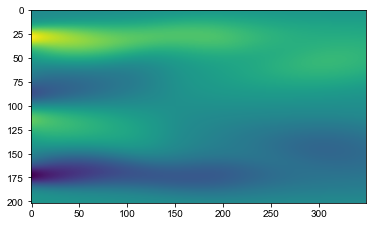

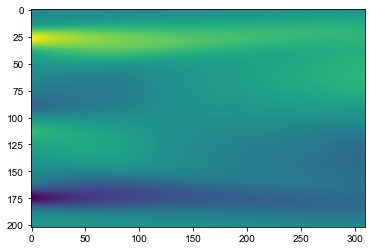

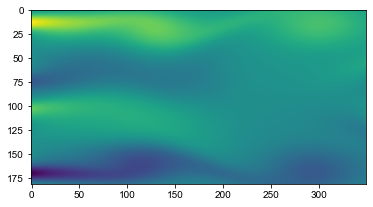

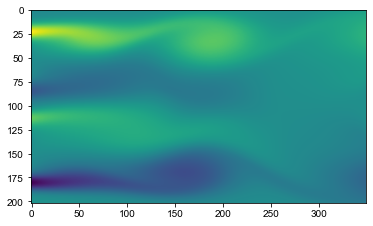

In [3]:
config_path = 'configs/config_vorticity_3cylinder_clean.yml'
config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
case_id_list = list(config['case_id_list'].keys())

def prepare_dataset(is_show=False):
    '''
    prepare a sets of dataset
    '''
    res = []
    fit_equ = FitEqu()

    for case_id in case_id_list:
        print('*' * 40, case_id)
        Nx, Ny = 500, 222
        dx, dy= 0.9/Nx, 0.4/Ny

        ref_params = config['case_id_list'][case_id]['ref_params']
        sim_params = config['case_id_list'][case_id]['sim_params']
        sim_params['niu'] = sim_params['mu'] / sim_params['rho']
        dt = sim_params['dt']

        # parameters for sparse regression
        x_range = config['case_id_list'][case_id]['x_range']
        y_range = config['case_id_list'][case_id]['y_range']
        boundary_x, boundary_y, boundary_t = 5, 5, 5  # avoid the select the boundary points due to polynomial fitting
        deg = 3             # polynomial degree
        
        #####################Prepare Dataset#####################
        # generate data and save to a folder
        U, V, W = fit_equ.load_dataset(case_id, config['dataset']['dataset_dir'])
        U, V, W = fit_equ.select_sub_domain(U, V, W, x_range, y_range)
        # non-dimensionlize data and dx, dy, dt
        U, V, W, dx, dy, dt, Re, coef_best = fit_equ.non_dimensionlize(U, V, W, dx, dy, dt, ref_params, sim_params)
        Nx, Ny, Nt = W.shape
        # sample points
        points = fit_equ.sample_points(Nx, Ny, boundary_x, boundary_y, boundary_t)        
        # plot the 1st frame 
        if is_show: fig = plt.figure(figsize=(6, 4)); plt.imshow(W[:, :, 0].T)

        #####################Prepare library#####################
        base_library = fit_equ.cal_derivatives(
            U, V, W, points, boundary_x, boundary_y, boundary_t, dx, dy, dt, deg)
        X_library, y_library, names = fit_equ.parse_library(base_library)
        # check data
        is_nan = fit_equ.check_library(X_library, y_library)
        if is_nan: continue
        df_all = pd.DataFrame(np.concatenate([X_library, y_library], axis=1))
        # check the fitting of the target equation
        fit_equ.check_equ(X_library, y_library, Re)
        # # visualization library
        # if is_show: fig = plt.figure(); df_all.plot(); plt.xlim([0, 2000])
        # print(df_all.describe())
        # df_all.to_csv('../results/test_vorticity_data.csv')

        #####################Fit sequential sparse regression#####################
        coef = fit_equ.fit(X_library, y_library)
        coef_res = [(each[0], round(each[1], 6)) for each in list(zip(names, coef.tolist())) if abs(each[1]) >= 1e-3]
        coef_res = sorted(coef_res, key=lambda x: abs(x[1]), reverse=True)
        print(colored(f'coef_res: {coef_res}', 'red'))
        # add to the total results
        res.append([sim_params['niu'], ref_params['l_ref'], ref_params['v_ref'], 
                sim_params['rho'], ref_params['p_ref'], Nx*dx, Ny*dy, Re, coef_best] + coef.tolist())
    
    df = pd.DataFrame(res)
    return df

df = prepare_dataset(True)
df.to_csv('../dataset/dataset_vorticity_flow3D.csv')

In [4]:
df = pd.read_csv('../dataset/dataset_vorticity_flow3D.csv')
df = df.rename(columns={
    '0': 'niu',
    '1': 'diameter',
    '2': 'v_init',
    '3': 'density',
    '4': 'p_init',
    '5': 'lx',
    '6': 'ly',
    '7': 'Re',
    '8': 'coef_best',
    })
df['mu'] = df['niu'] * df['density']
# print(df.head())
df.to_csv('../dataset/dataset_vorticity_flow3D.csv')

In [5]:
print(df[['Re', 'coef_best', '14', '20']])

           Re  coef_best        14        20
0   50.000000   0.020000  0.021220 -0.992462
1   80.000518   0.012500  0.012553 -0.924042
2   90.000000   0.011111  0.012629 -0.990895
3  100.000000   0.010000  0.011071 -0.994117


In [6]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_coef, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_coef = output_coef
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_coef].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in = self.basis_list[0], self.basis_list[1]
        return basis1_in, basis2_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + coef[1] * self.basis2_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        # print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        # print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def fit_pattern_search(self, seed):
        '''
        pattern search
        '''
        def get_coordinates(a, b, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for a_ in [a-delta, a, a+delta]:
                for b_ in [b-delta, b, b+delta]:
                    if [a_, b_] != [a, b]:
                        coord_all.append([a_, b_])
            return coord_all
        
        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(pi_in, self.y)
            y_pred = reg.predict(pi_in)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        b = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        # a, b = -1, 0
        coef = np.array([a, b]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, b, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a, b])
                break

            r2_bounds_val = []
            for [a_, b_] in candidate_coord:
                coef_temp = np.array([a_, b_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a, b] = candidate_coord[highest_index]
                coef = np.array([a, b]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'b': b, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef_final, coef_w_final = opt(coef)
        return r2, reg_coef_final, coef_w_final


def recover_coef1(seed):
    input_list = ['mu', 'diameter', 'v_init', 'density', 'p_init']
    output_coef = '14'

    D_in = np.mat('-1, -1, 1; 1, 0, 0; 1, -1, 0; -3, 0, 1; -1, -2, 1').T
    D_out = np.mat('0;, 0; 0')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([-1, 1, 1, 1, 0]).reshape(-1, 1)
    basis2_in = np.array([-1, 1, -1, 0, 1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)
    # dimensionless_learning.check_dimension(coef=[-1, 0])

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)


for i in range(10):
    recover_coef1(seed=i)

final r2 0.9783817150289186 [ 1. -1. -1. -1.  0.] [[1.06751581]]
final r2 0.9783817150289186 [ 1. -1. -1. -1.  0.] [[1.06751581]]
